<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/Ejercicio_Jumanji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

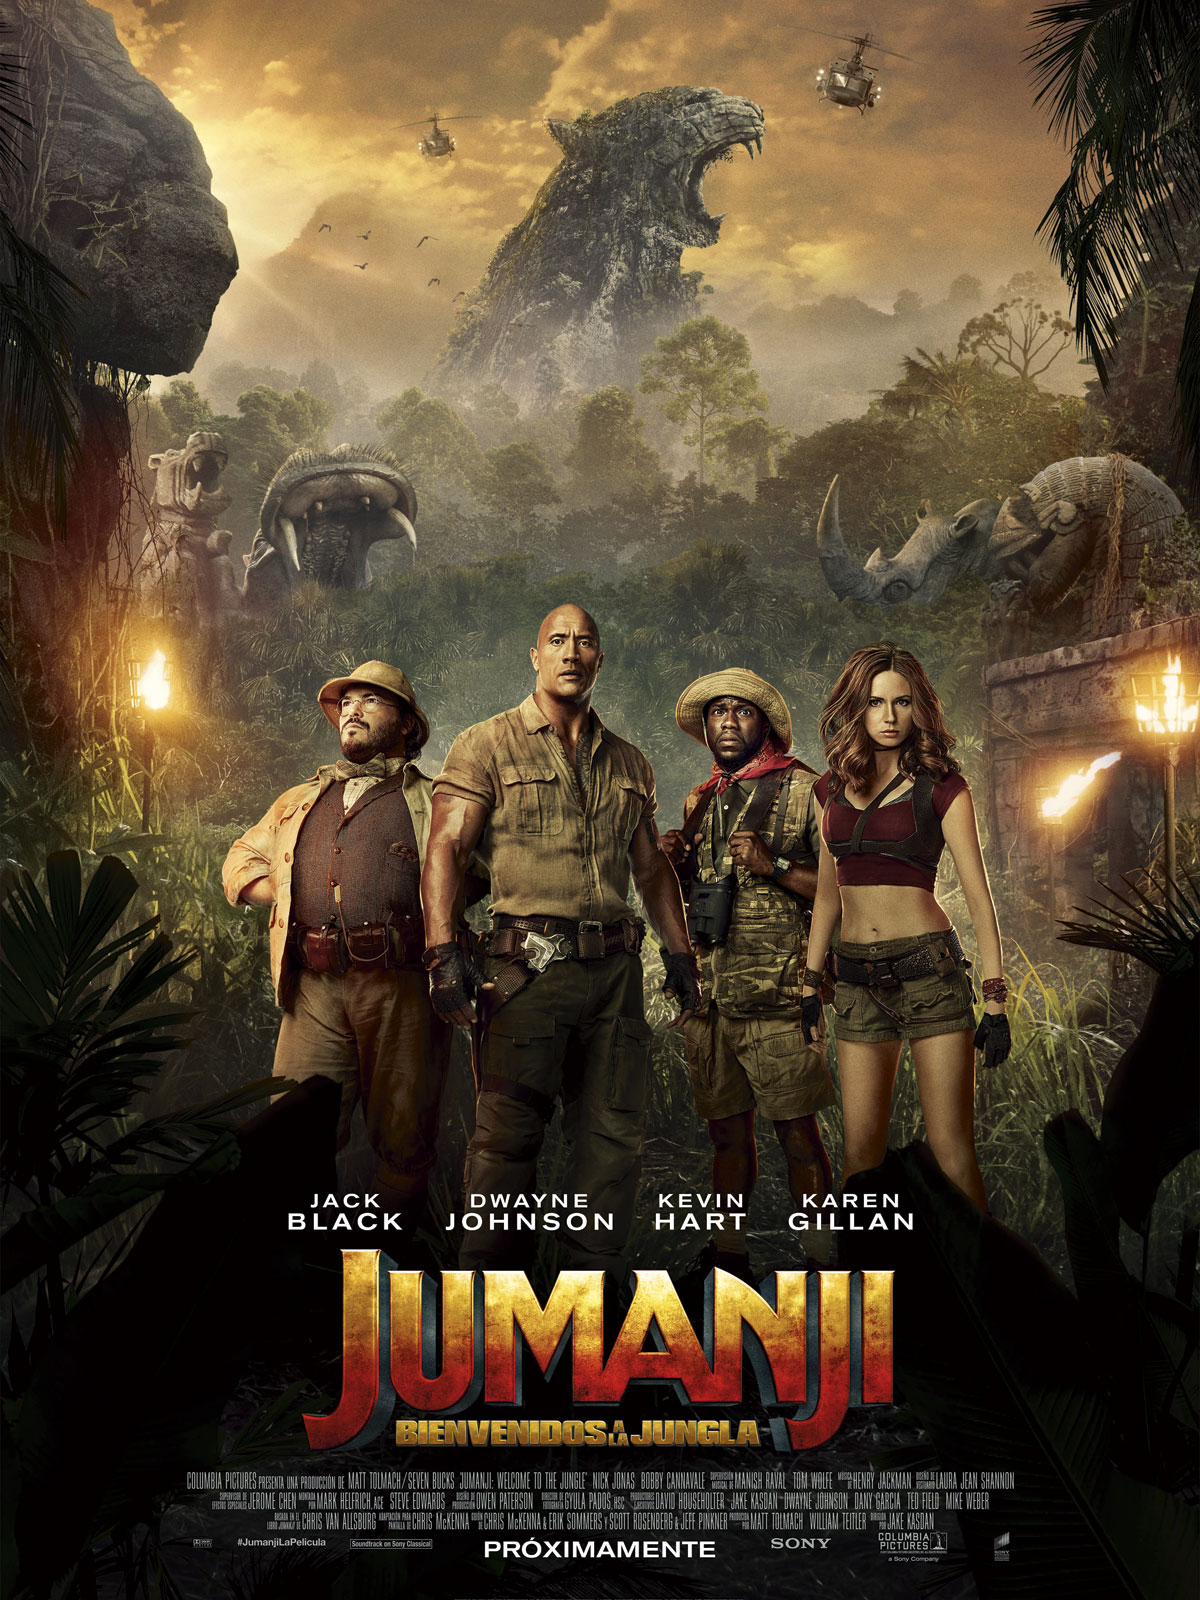

# Ejercicio Jumanji - Bienvenidos a la jungla

Wellcome to Jumanji dear adventurers. Unfortunately not everything are good news, some players have been playing to the game and, as a result of they dumb plays, a stampede of cats and dogs is now running in the real world.

As a fellow explorer I am sure that you understand the urgency of the situation. To solve it, we need to create a computer vision algorithm using CNNs to detect the cats and the dogs.

In order to do so we require the following steps:

- Create an image preprocessing pipeline to treat the images that we are providing. Perform data augmentation over the dataset, at least rotations.

- Test several architechtures (at least 3) and evaluate their performance over the dataset.

- Visualize the feature maps of some of the early and late layers of the models developed. ¿Is there any feature which could be explained through them?

- Finally select the model which performs the best over the whole dataset and explain why.

Fellow adventurer, thanks for your time, Jumanji will not forget your efforts.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

--2022-01-01 18:37:36--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   197MB/s    in 0.3s    

2022-01-01 18:37:37 (197 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/vali

In [2]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

## Visualizacion de los datos


In [7]:
fich_cats = glob("./cats_and_dogs_filtered/train/cats/*")
fich_cats[0]

'./cats_and_dogs_filtered/train/cats/cat.240.jpg'

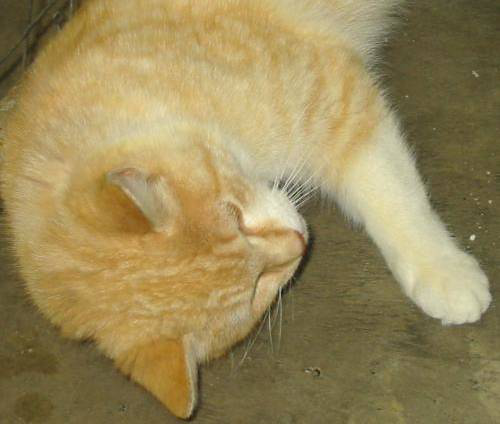

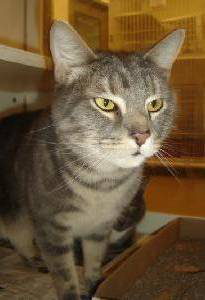

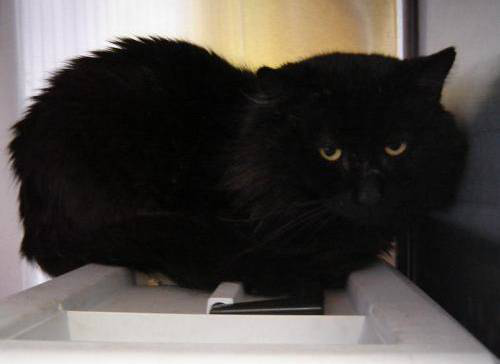

In [8]:
for fich in fich_cats[0:3]:
    imagen = load_img(fich)
    display(imagen)
    print()

In [9]:
fich_dogs = glob("./cats_and_dogs_filtered/train/dogs/*")
fich_dogs[0]

'./cats_and_dogs_filtered/train/dogs/dog.562.jpg'

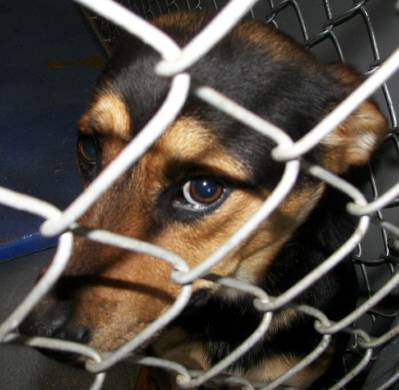

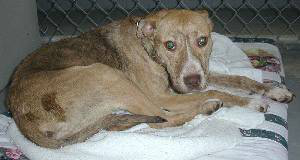

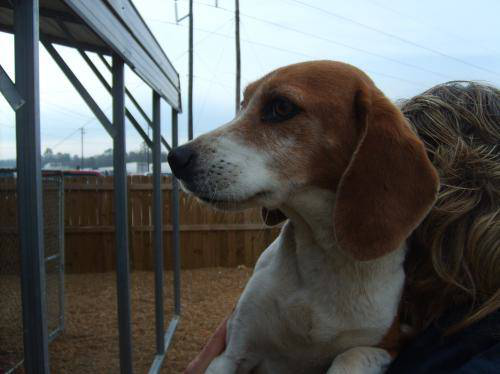

In [11]:
for fich in fich_dogs[0:3]:
    imagen = load_img(fich)
    display(imagen)
    print()

## Data aumentation: rotation.



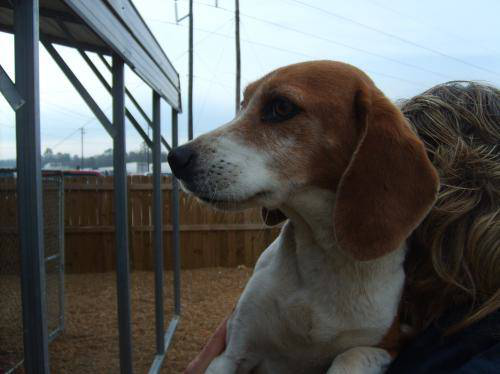

In [14]:
imagen = load_img(fich)
imagen

In [44]:
def preprocess_input(x):
     return x/255.


In [45]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=60)

In [46]:
imagen_num = np.expand_dims(np.array(imagen), axis=0)

In [47]:
imagen_num.shape

(1, 374, 500, 3)

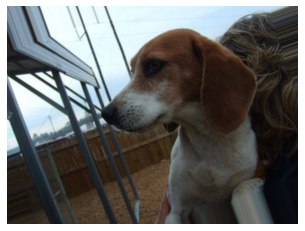

In [48]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

## Image size


In [49]:
img_width, img_height = 120, 120

normed_dims = (img_height, img_width)

## Red

In [54]:
model = Sequential()

model.add(Conv2D(8, (3,3), activation='relu', input_shape=normed_dims+(3,)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())

model.add(Dropout(0.3))
model.add(Dense(20, activation='relu', kernel_regularizer="l2")) # regularizador L2
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 118, 118, 8)       224       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 59, 59, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 57, 16)        1168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 28, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 32)      

In [ ]:
model.sh